# Exploring COVID-19 numbers: the data acquisition process

### Environment log:

(1) Using the "analytics3" anaconda environment; installing python packages directly through *pip* command.  
(2) Installed *pyvirtualenv*, *selenium*, and *[bs4](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#)* packages.  
(3) Installed *chromedriver* through "pip install chromedriver".  

(4) Got this error when initializing the Display function:
> display = Display(visible=0, size=(800,600))
> display.start()  
>> FileNotFoundError: [Errno 2] No such file or directory: 'Xvfb': 'Xvfb'
>> EasyProcessError: start error EasyProcess cmd_param=['Xvfb', '-help'] cmd=['Xvfb', '-help'] oserror=[Errno 2] No such file or directory: 'Xvfb': 'Xvfb' return_code=None stdout="None" stderr="None" timeout_happened=False>

**Solution found in: https://bugs.debian.org/cgi-bin/bugreport.cgi?bug=860501**   
 
(5) Installed the system package xvfb through the shell line: *sudo apt-get install xvfb*.

- When running the "driver = webdriver.Chrome()" python command, I received the following error:  
> driver = webdriver.Chrome()
>> FileNotFoundError: [Errno 2] No such file or directory: 'chromedriver': 'chromedriver'  

(6) Even though, since I'm using conda environment I have set the chromedriver path before:  
> chromeDriverPath = '~/anaconda3/envs/analytics3/'

The solution was to create a symbolic link in the path shown above, through the system bash, which made it work properly:  
> $ ln -s ~/anaconda3/envs/analytics3/chromedriver-Linux64 chromedriver  

(7) There are some broken links in the BMH oficial page: it misses the "https://portalarquivos.saude.gov.br/" portion of the link. We defined a function to address this issue.


## Epidemiological bulletins from World Health Organization - WHO
https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports/  
https://github.com/danielsteman/COVID-19_WHO  
https://github.com/danielsteman/COVID-19_WHO/blob/master/WHO_webscrape.ipynb (the author uses PyPDF2)

## Epidemiological bulletins from Brazilian Ministry of Health
https://www.saude.gov.br/boletins-epidemiologicos
  - Coronavírus/COVID-19  
  - Dengue

## COVID-19 pandemic: official dashboard of the Ministry of Health of Brazil
https://covid.saude.gov.br/

### Initial statements

In [161]:
import sys
print(sys.version)

3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]


In [162]:
from pyvirtualdisplay import Display
from selenium import webdriver

## BeautifulSoup - BeautifulSoup is not needed at this time, since there's no parsing.
#from bs4 import 

In [163]:
# Definição de parâmetros
url = 'https://covid.saude.gov.br'
chromeDriverPath = '/home/tbnsilveira/anaconda3/envs/analytics/chromedriver'

### Web browsing

In this step of our data crawling we want to access the webpage through the Chromium driver. It is then appropriate to create some functions both for the page access as for its content analysis. However, it would be only possible if we know the page structure. In order to reach it, at this time we will try to read and explore it, trying to find the patterns and links we are looking for.

In [164]:
# Display starting:
display = Display(visible=0, size=(800,600))
display.start()

In [165]:
# Open the Chromium.driver for the intended page:
driver = webdriver.Chrome(chromeDriverPath)

In [166]:
# Reading the page content and saving it specifying its encoding scheme:
driver.get(url)
page = driver.page_source.encode('utf-8')

### Initial exploration

In [167]:
# How large is the loaded page?
print(len(page))
# Data streaming type is expected:
print(type(page))

1157264
<class 'bytes'>


In [168]:
## Showing only the first 2k positions of the bytes stream:
print(page[:2000])

b'<!DOCTYPE html><html xmlns="http://www.w3.org/1999/xhtml" lang="en" class="plt-phablet plt-desktop md hydrated" mode="md"><head>\n    <meta charset="utf-8" /><style data-styles="">ion-select-popover,ion-select,ion-select-option,ion-menu-button,ion-menu,ion-menu-toggle,ion-action-sheet,ion-fab-button,ion-fab,ion-fab-list,ion-refresher-content,ion-refresher,ion-back-button,ion-backdrop,ion-alert,ion-loading,ion-toast,ion-card,ion-card-content,ion-card-header,ion-card-subtitle,ion-card-title,ion-item-option,ion-item-options,ion-item-sliding,ion-infinite-scroll-content,ion-infinite-scroll,ion-reorder,ion-reorder-group,ion-segment-button,ion-segment,ion-tab-button,ion-tab-bar,ion-chip,ion-modal,ion-popover,ion-searchbar,ion-app,ion-buttons,ion-content,ion-footer,ion-header,ion-router-outlet,ion-title,ion-toolbar,ion-route,ion-route-redirect,ion-router,ion-router-link,ion-avatar,ion-badge,ion-thumbnail,ion-col,ion-grid,ion-row,ion-nav,ion-nav-link,ion-slide,ion-slides,ion-checkbox,ion-img,

------------------

Once the website is loaded, **BeautifulSoup is typically used to mine its content and explore links of interest**. In this case, however, **the new portal made available by BMH was created in Firebase**. That is, there is no link to the database, but a response to the action of clicking the button.

Using Chrome's inspection tool, we can locate the element related to downloading the data and then emulate its click through the Selenium library.

In [169]:
## Path of the element from Chrome inspection tool:
xpathElement = '/html/body/app-root/ion-app/ion-router-outlet/app-home/ion-content/div[1]/div[2]/ion-button'

## Element corresponding to "Arquivo CSV" button:
dataDownloader = driver.find_element_by_xpath(xpathElement)

In [170]:
dataDownloader.click()

The steps above allowed us to download the CSV file to the default downloading directory. An open issue from this script is to set the specific file destiny. There are some references saying Selenium does not support dialogue boxes. Other references explore ways to do it out:

https://medium.com/@moungpeter/how-to-automate-downloading-files-using-python-selenium-and-headless-chrome-9014f0cdd196

---------------------

### Reading the downloaded CSV file:

In [171]:
import os
import glob

To figure out how to select the last downloaded file in a directory, I used the code available in https://stackoverflow.com/questions/39327032/how-to-get-the-latest-file-in-a-folder-using-python.

In [172]:
## Picking the last XLSX downloaded file:
list_of_files = glob.glob('/home/tbnsilveira/Downloads/*.xlsx') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)

/home/tbnsilveira/Downloads/HIST_PAINEL_COVIDBR_01jun2020.xlsx


In [84]:
#latest_file = list_of_files[2]
#latest_file

In [5]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [173]:
covidData = pd.read_excel(latest_file)

In [174]:
covidData

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-26,9,210147125.0,1,0,0,0,NaN,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-27,9,210147125.0,1,0,0,0,NaN,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-28,9,210147125.0,1,0,0,0,NaN,NaN
3,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-29,9,210147125.0,2,1,0,0,NaN,NaN
4,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-03-01,10,210147125.0,2,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142794,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,Brasília,2020-05-28,22,3015268.0,8300,539,142,9,NaN,NaN
142795,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,Brasília,2020-05-29,22,3015268.0,8722,422,154,12,NaN,NaN
142796,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,Brasília,2020-05-30,22,3015268.0,9474,752,162,8,NaN,NaN
142797,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,Brasília,2020-05-31,23,3015268.0,9780,306,170,8,NaN,NaN


-----------------

In the way this script was initialy built, it was important to remove the CSV file after reading it, thus preventing the most current versions from being downloaded under another name. However, in the second week of May, the BMH changed the file format to XLSX, thus requiring to adapt the script. In this case, I choose to read the last downloaded file, then keeping all the copies in my system. In the case you don't want these copies, you can just uncomment the line below:

In [175]:
## In some situations you'll have to replace "~/" by the full local address (/home/user...)
#os.remove(latest_file)

------------------

## Data wrangling 

In [176]:
covidData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142799 entries, 0 to 142798
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   regiao                 142799 non-null  object 
 1   estado                 142702 non-null  object 
 2   municipio              139850 non-null  object 
 3   coduf                  142799 non-null  int64  
 4   codmun                 140536 non-null  float64
 5   codRegiaoSaude         139850 non-null  float64
 6   nomeRegiaoSaude        139850 non-null  object 
 7   data                   142799 non-null  object 
 8   semanaEpi              142799 non-null  int64  
 9   populacaoTCU2019       142113 non-null  float64
 10  casosAcumulado         142799 non-null  int64  
 11  casosNovos             142799 non-null  int64  
 12  obitosAcumulado        142799 non-null  int64  
 13  obitosNovos            142799 non-null  int64  
 14  Recuperadosnovos       44 non-null  

### Adjusting the datetime type data:

From the information above, there are 38 instances with null value. First we must check which kind of data are in these lines, then deciding if will remove them or not.

In [177]:
### Which datetype data is null?
covidData[covidData.data.isnull()]

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos


In [178]:
covidData.loc[4176:4182]

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos
4176,Norte,AC,Santa Rosa do Purus,12,120043.0,12002.0,Baixo Acre e Purus,2020-05-23,21,6540.0,2,0,0,0,NaN,NaN
4177,Norte,AC,Santa Rosa do Purus,12,120043.0,12002.0,Baixo Acre e Purus,2020-05-24,22,6540.0,2,0,0,0,NaN,NaN
4178,Norte,AC,Santa Rosa do Purus,12,120043.0,12002.0,Baixo Acre e Purus,2020-05-25,22,6540.0,2,0,0,0,NaN,NaN
4179,Norte,AC,Santa Rosa do Purus,12,120043.0,12002.0,Baixo Acre e Purus,2020-05-26,22,6540.0,3,1,0,0,NaN,NaN
4180,Norte,AC,Santa Rosa do Purus,12,120043.0,12002.0,Baixo Acre e Purus,2020-05-27,22,6540.0,8,5,0,0,NaN,NaN
4181,Norte,AC,Santa Rosa do Purus,12,120043.0,12002.0,Baixo Acre e Purus,2020-05-28,22,6540.0,11,3,0,0,NaN,NaN
4182,Norte,AC,Santa Rosa do Purus,12,120043.0,12002.0,Baixo Acre e Purus,2020-05-29,22,6540.0,11,0,0,0,NaN,NaN


#### Dropping the NaN values:

In [179]:
covidData2 = covidData.copy()

In [180]:
covidData2.dropna(axis=0, subset=['data'], inplace=True)

In [181]:
covidData2.reset_index(drop=True, inplace=True)

In [182]:
covidData2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142799 entries, 0 to 142798
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   regiao                 142799 non-null  object 
 1   estado                 142702 non-null  object 
 2   municipio              139850 non-null  object 
 3   coduf                  142799 non-null  int64  
 4   codmun                 140536 non-null  float64
 5   codRegiaoSaude         139850 non-null  float64
 6   nomeRegiaoSaude        139850 non-null  object 
 7   data                   142799 non-null  object 
 8   semanaEpi              142799 non-null  int64  
 9   populacaoTCU2019       142113 non-null  float64
 10  casosAcumulado         142799 non-null  int64  
 11  casosNovos             142799 non-null  int64  
 12  obitosAcumulado        142799 non-null  int64  
 13  obitosNovos            142799 non-null  int64  
 14  Recuperadosnovos       44 non-null  

--------------------------

#### Setting the datetime64 type to the "Date" column (it's called "data" in Portuguese):

In [183]:
type(covidData2.data)

pandas.core.series.Series

In [184]:
type(covidData2.data[2])

str

In [185]:
covidData2.data = covidData2.data.astype('datetime64')

-----------------

## Visualizing some data:

In [186]:
covidData2

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-26,9,210147125.0,1,0,0,0,NaN,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-27,9,210147125.0,1,0,0,0,NaN,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-28,9,210147125.0,1,0,0,0,NaN,NaN
3,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-29,9,210147125.0,2,1,0,0,NaN,NaN
4,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-03-01,10,210147125.0,2,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142794,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,Brasília,2020-05-28,22,3015268.0,8300,539,142,9,NaN,NaN
142795,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,Brasília,2020-05-29,22,3015268.0,8722,422,154,12,NaN,NaN
142796,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,Brasília,2020-05-30,22,3015268.0,9474,752,162,8,NaN,NaN
142797,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,Brasília,2020-05-31,23,3015268.0,9780,306,170,8,NaN,NaN


In [187]:
## Showing the line with the highest number of deaths:
idx = covidData2.obitosAcumulado.idxmax()
covidData2.iloc[idx]

regiao                                Brasil
estado                                   NaN
municipio                                NaN
coduf                                     76
codmun                                   NaN
codRegiaoSaude                           NaN
nomeRegiaoSaude                          NaN
data                     2020-06-01 00:00:00
semanaEpi                                 23
populacaoTCU2019                 2.10147e+08
casosAcumulado                        526447
casosNovos                             12247
obitosAcumulado                        29937
obitosNovos                              623
Recuperadosnovos                      211080
emAcompanhamentoNovos                 285430
Name: 96, dtype: object

----------

#### Exploring only SC municipalities

In [188]:
covid_SC = covidData2[covidData2.estado == 'SC']

In [189]:
covid_SC.municipio.unique()

array([nan, 'Abdon Batista', 'Abelardo Luz', 'Agrolândia', 'Agronômica',
       'Água Doce', 'Águas de Chapecó', 'Águas Frias', 'Águas Mornas',
       'Alfredo Wagner', 'Alto Bela Vista', 'Anchieta', 'Anita Garibaldi',
       'Antônio Carlos', 'Arabutã', 'Araquari', 'Araranguá', 'Armazém',
       'Arvoredo', 'Ascurra', 'Atalanta', 'Aurora',
       'Balneário Arroio do Silva', 'Balneário Camboriú',
       'Balneário Barra do Sul', 'Balneário Gaivota', 'Barra Velha',
       'Benedito Novo', 'Biguaçu', 'Blumenau', 'Bombinhas', 'Botuverá',
       'Braço do Norte', 'Brusque', 'Caçador', 'Caibi', 'Camboriú',
       'Campo Erê', 'Campos Novos', 'Canelinha', 'Canoinhas', 'Capinzal',
       'Capivari de Baixo', 'Catanduvas', 'Caxambu do Sul', 'Chapecó',
       'Cocal do Sul', 'Concórdia', 'Cordilheira Alta', 'Coronel Freitas',
       'Corupá', 'Criciúma', 'Cunha Porã', 'Cunhataí', 'Curitibanos',
       'Descanso', 'Dionísio Cerqueira', 'Dona Emma', 'Doutor Pedrinho',
       'Entre Rios', 'Faxin

In [190]:
sns.set_style("whitegrid")

In [191]:
cidade = 'Florianópolis'

Text(0.5, 1.0, 'Número de casos COVID-19 acumulados em Florianópolis, SC, em 21/05/2020')

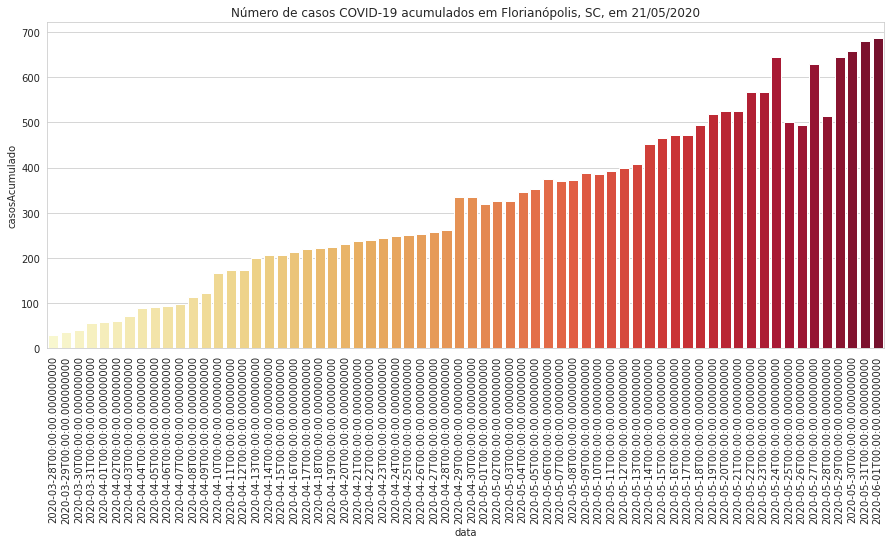

In [192]:
fig, ax = plt.subplots(figsize=(15,6))

ax = sns.barplot(x='data', y='casosAcumulado', data=covid_SC[covid_SC['municipio'] == cidade], palette='YlOrRd')
plt.xticks(rotation='vertical');
plt.title('Número de casos COVID-19 acumulados em {0}, SC, em 21/05/2020'.format(cidade))

In [193]:
covid_SC[covid_SC['municipio'] == 'Blumenau']

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos
117420,Sul,SC,Blumenau,42,420240.0,42006.0,Médio Vale do Itajaí,2020-03-28,13,357199.0,12,0,0,0,NaN,NaN
117421,Sul,SC,Blumenau,42,420240.0,42006.0,Médio Vale do Itajaí,2020-03-29,14,357199.0,12,0,0,0,NaN,NaN
117422,Sul,SC,Blumenau,42,420240.0,42006.0,Médio Vale do Itajaí,2020-03-30,14,357199.0,12,0,0,0,NaN,NaN
117423,Sul,SC,Blumenau,42,420240.0,42006.0,Médio Vale do Itajaí,2020-03-31,14,357199.0,19,7,0,0,NaN,NaN
117424,Sul,SC,Blumenau,42,420240.0,42006.0,Médio Vale do Itajaí,2020-04-01,14,357199.0,19,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117481,Sul,SC,Blumenau,42,420240.0,42006.0,Médio Vale do Itajaí,2020-05-28,22,357199.0,572,74,4,1,NaN,NaN
117482,Sul,SC,Blumenau,42,420240.0,42006.0,Médio Vale do Itajaí,2020-05-29,22,357199.0,607,35,4,0,NaN,NaN
117483,Sul,SC,Blumenau,42,420240.0,42006.0,Médio Vale do Itajaí,2020-05-30,22,357199.0,614,7,4,0,NaN,NaN
117484,Sul,SC,Blumenau,42,420240.0,42006.0,Médio Vale do Itajaí,2020-05-31,23,357199.0,616,2,4,0,NaN,NaN


----------------

## Visualizing the number of cases by state

#### Preparing the dataset only with tha state data:

In [194]:
## Getting the last date from data:
lastDay = covidData2.data.max()
lastDay

Timestamp('2020-06-01 00:00:00')

In [195]:
covidLastDay = covidData2[(covidData2.data == lastDay) &
                         (covidData2.estado.isna() == False) & 
                         (covidData2.municipio.isna() == True) &
                         (covidData2.populacaoTCU2019.isna() == False)]

In [196]:
covidLastDay = covidLastDay[['regiao','estado','data','populacaoTCU2019','casosAcumulado','obitosAcumulado']]

In [197]:
covidLastDay

,regiao,estado,data,populacaoTCU2019,casosAcumulado,obitosAcumulado
170,Norte,RO,2020-06-01,1777225.0,5172,159
245,Norte,AC,2020-06-01,881935.0,6326,161
324,Norte,AM,2020-06-01,4144597.0,41774,2071
396,Norte,RR,2020-06-01,605761.0,3692,116
471,Norte,PA,2020-06-01,8602865.0,38046,2925
545,Norte,AP,2020-06-01,845731.0,9890,228
620,Norte,TO,2020-06-01,1572866.0,4345,76
693,Nordeste,MA,2020-06-01,7075181.0,35297,976
767,Nordeste,PI,2020-06-01,3273227.0,5119,168
844,Nordeste,CE,2020-06-01,9132078.0,50504,3188


#### Normalizing data:

In [198]:
normalCovid = covidLastDay.copy()

In [199]:
## Contamination rate (pct of population)
normalCovid['contamRate'] = (normalCovid['casosAcumulado'] / normalCovid['populacaoTCU2019']) * 100
## Lethality rate (pct of cases)
normalCovid['lethality_pct'] = (normalCovid['obitosAcumulado'] / normalCovid['casosAcumulado']) * 100
## Death rate (pct of population)
normalCovid['deathRate'] = (normalCovid['obitosAcumulado'] / normalCovid['populacaoTCU2019']) * 100

In [200]:
normalCovid['casosAcumulado'].max()

111296

In [201]:
normalCovid['obitosAcumulado'].max()

7667

In [202]:
normalCovid.lethality_pct.idxmax()

1598

In [203]:
normalCovid.sort_values(by=['estado'])

,regiao,estado,data,populacaoTCU2019,casosAcumulado,obitosAcumulado,contamRate,lethality_pct,deathRate
245,Norte,AC,2020-06-01,881935.0,6326,161,0.717286,2.545052,0.018255
1168,Nordeste,AL,2020-06-01,3337357.0,10837,461,0.324718,4.253945,0.013813
324,Norte,AM,2020-06-01,4144597.0,41774,2071,1.007915,4.957629,0.049969
545,Norte,AP,2020-06-01,845731.0,9890,228,1.169403,2.305359,0.026959
1335,Nordeste,BA,2020-06-01,14873064.0,18898,701,0.127062,3.709387,0.004713
844,Nordeste,CE,2020-06-01,9132078.0,50504,3188,0.553040,6.312371,0.034910
2262,Centro-Oeste,DF,2020-06-01,3015268.0,10510,171,0.348559,1.627022,0.005671
1509,Sudeste,ES,2020-06-01,4018650.0,14069,614,0.350093,4.364205,0.015279
2175,Centro-Oeste,GO,2020-06-01,7018354.0,3906,127,0.055654,3.251408,0.001810
693,Nordeste,MA,2020-06-01,7075181.0,35297,976,0.498885,2.765108,0.013795


#### Dataframe queries:

In [204]:
normalCovid.query("estado=='AC'")

,regiao,estado,data,populacaoTCU2019,casosAcumulado,obitosAcumulado,contamRate,lethality_pct,deathRate
245,Norte,AC,2020-06-01,881935.0,6326,161,0.717286,2.545052,0.018255


In [205]:
normalCovid.query("obitosAcumulado > 1000")

,regiao,estado,data,populacaoTCU2019,casosAcumulado,obitosAcumulado,contamRate,lethality_pct,deathRate
324,Norte,AM,2020-06-01,4144597.0,41774,2071,1.007915,4.957629,0.049969
471,Norte,PA,2020-06-01,8602865.0,38046,2925,0.442248,7.688062,0.034000
844,Nordeste,CE,2020-06-01,9132078.0,50504,3188,0.553040,6.312371,0.034910
1082,Nordeste,PE,2020-06-01,9557071.0,34900,2875,0.365175,8.237822,0.030082
1598,Sudeste,RJ,2020-06-01,17264943.0,54530,5462,0.315842,10.016505,0.031636
1695,Sudeste,SP,2020-06-01,45919049.0,111296,7667,0.242374,6.888837,0.016697


In [206]:
normalCovid.query("obitosAcumulado > 1000")

,regiao,estado,data,populacaoTCU2019,casosAcumulado,obitosAcumulado,contamRate,lethality_pct,deathRate
324,Norte,AM,2020-06-01,4144597.0,41774,2071,1.007915,4.957629,0.049969
471,Norte,PA,2020-06-01,8602865.0,38046,2925,0.442248,7.688062,0.034000
844,Nordeste,CE,2020-06-01,9132078.0,50504,3188,0.553040,6.312371,0.034910
1082,Nordeste,PE,2020-06-01,9557071.0,34900,2875,0.365175,8.237822,0.030082
1598,Sudeste,RJ,2020-06-01,17264943.0,54530,5462,0.315842,10.016505,0.031636
1695,Sudeste,SP,2020-06-01,45919049.0,111296,7667,0.242374,6.888837,0.016697


-----------------

### Four-Quadrant chart via Plotly:

In [207]:
import plotly.express as px
import plotly.graph_objects as go
## List of colormaps available in: https://plotly.com/python/builtin-colorscales/

In [208]:
fig = px.scatter(normalCovid, x='lethality_pct', y='contamRate',
                 size='deathRate', color='obitosAcumulado', text='estado',
                 size_max=40, color_continuous_scale='Sunsetdark')

fig.update_traces(textposition='middle center',
                  textfont=dict(family="sans serif",
                                size=13))

fig.update_layout(
    ## Chart general set:
    height=520,
    width=980,
    plot_bgcolor='rgb(245,245,245)',
    title_text='Relação entre número de casos e letalidade da COVID-19 no Brasil, por estado - {0}'.format(lastDay.date()),
    xaxis_title="<b>Letalidade (% óbitos/casos)</b>",
    yaxis_title="<b>Contaminação (% casos/população)</b>",
    hovermode=False,  #Disable the hover information.
    ## Axis ranges:
    xaxis=dict(
        autorange=False,
        range=[0, 12],
        type="linear"
    ),
    yaxis=dict(
        autorange=False,
        range=[0, 0.8],
        type="linear"),
    ## Adjusting the colorbar title:
    coloraxis=dict(
        colorbar=dict(
            title=dict(
                text='<b>Óbitos <br>acumulados</b>'
            )
        )),
    ## Vertical and horizontal lines
    shapes=[
        dict(
          type= 'line',
          yref= 'y', y0= 0, y1= 0.8,
          xref= 'x', x0= 6, x1= 6,
          line=dict(
                color="gray",
                width=1,
                dash="dashdot",
                )),
        dict(
          type= 'line',
          yref= 'y', y0= 0.4, y1= 0.4,
          xref= 'x', x0= 0, x1= 12,
          line=dict(
                color="gray",
                width=1,
                dash="dashdot",
                ))
        ],    
    ## Points annotations:
    annotations=[
        go.layout.Annotation(
            text='<b>Zona crítica</b>',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=.98,
            y=.99,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#E9967A',
            font=dict(
                color='DarkRed'),
            width=110,
            height=20),
        go.layout.Annotation(
            text='Alta letalidade',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=.98,
            y=.01,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#DCDCDC',
            font=dict(
                color='black'),
            width=110,
            height=20),
        go.layout.Annotation(
            text='Alta contaminação',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=0,
            y=.99,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#DCDCDC',
            font=dict(
                color='DarkRed'),
            width=110,
            height=20),
        go.layout.Annotation(
            text='Zona controlada',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=0,
            y=.01,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#DCDCDC',
            font=dict(
                color='black'),
            width=110,
            height=20),
    ]
)

fig.show()

The command below shows all the figure parameters, in the case it is needed to change something.

In [41]:
print(fig)

Figure({
    'data': [{'hovertemplate': ('lethality_pct=%{x}<br>contamRa' ... '%{marker.color}<extra></extra>'),
              'legendgroup': '',
              'marker': {'color': array([ 156.,  148., 2052.,  116., 2923.,  222.,   73.,  955.,  161., 3010.,
                                          305.,  360., 2807.,  443.,  158.,  667.,  271.,  604., 5344., 7615.,
                                          182.,  143.,  224.,   20.,   61.,  124.,  170.]),
                         'coloraxis': 'coloraxis',
                         'size': array([0.00877773, 0.01678128, 0.04951024, 0.01914947, 0.03397705, 0.02624948,
                                        0.00464121, 0.01349789, 0.00491869, 0.03296073, 0.00869726, 0.0089594 ,
                                        0.02937092, 0.01327398, 0.00687346, 0.00448462, 0.00128019, 0.01502992,
                                        0.0309529 , 0.01658353, 0.00159175, 0.00199587, 0.00196884, 0.00071969,
                                        0

#### Generating the Four-Quadrant graphic with English content:

In [162]:
fig = px.scatter(normalCovid, x='lethality_pct', y='contamRate',
                 size='deathRate', color='obitosAcumulado', text='estado',
                 size_max=40, color_continuous_scale='Sunsetdark')

fig.update_traces(textposition='middle center',
                  textfont=dict(family="sans serif",
                                size=13))

fig.update_layout(
    ## Chart general set:
    height=520,
    width=980,
    plot_bgcolor='rgb(245,245,245)',
   # title_text='Relação entre número de casos e letalidade da COVID-19 no Brasil, por estado - 2020.05.22',
    xaxis_title="<b>Lethality (% deaths/cases)</b>",
    yaxis_title="<b>Contamination (% cases/population)</b>",
    hovermode=False,  #Disable the hover information.
    ## Axis ranges:
    xaxis=dict(
        autorange=False,
        range=[0, 12],
        type="linear"
    ),
    yaxis=dict(
        autorange=False,
        range=[0, 0.8],
        type="linear"),
    ## Adjusting the colorbar title:
    coloraxis=dict(
        colorbar=dict(
            title=dict(
                text='<b>Accumulated<br> deaths</b>'
            )
        )),
    ## Vertical and horizontal lines
    shapes=[
        dict(
          type= 'line',
          yref= 'y', y0= 0, y1= 0.8,
          xref= 'x', x0= 6, x1= 6,
          line=dict(
                color="gray",
                width=1,
                dash="dashdot",
                )),
        dict(
          type= 'line',
          yref= 'y', y0= 0.4, y1= 0.4,
          xref= 'x', x0= 0, x1= 12,
          line=dict(
                color="gray",
                width=1,
                dash="dashdot",
                ))
        ],    
    ## Points annotations:
    annotations=[
        go.layout.Annotation(
            text='<b>Critical zone</b>',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=.98,
            y=.99,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#E9967A',
            font=dict(
                color='DarkRed'),
            width=110,
            height=20),
        go.layout.Annotation(
            text='High lethality',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=.98,
            y=.01,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#DCDCDC',
            font=dict(
                color='black'),
            width=110,
            height=20),
        go.layout.Annotation(
            text='High contamination',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=0,
            y=.99,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#DCDCDC',
            font=dict(
                color='DarkRed'),
            width=110,
            height=20),
        go.layout.Annotation(
            text='Controlled zone',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=0,
            y=.01,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#DCDCDC',
            font=dict(
                color='black'),
            width=110,
            height=20),
    ]
)

fig.show()

---------------------------

### Four-Quadrant chart by date:

In [209]:
## Getting the last date from data:
lastDay = covidData2.data.max()
lastDay

Timestamp('2020-06-01 00:00:00')

In [210]:
covidLastDay = covidData2[(covidData2.data == lastDay) &
                         (covidData2.estado.isna() == False) & 
                         (covidData2.municipio.isna() == True) &
                         (covidData2.populacaoTCU2019.isna() == False)]

In [211]:
covidLastDay = covidLastDay[['regiao','estado','data','populacaoTCU2019','casosAcumulado','obitosAcumulado']]

In [212]:
def covidDB_byDate(covidDB, timestamp):
    '''Create a COVID-19 subset from a pandas.Timestamp list.'''
    ### Selecting data:
    covidSelected = covidDB[(covidDB.data.isin(timestamp)) &
                         (covidDB.estado.isna() == False) & 
                         (covidDB.municipio.isna() == True) &
                         (covidDB.populacaoTCU2019.isna() == False)]
    ### Normalizing data:
    ## Contamination rate (pct covidSelected population)
    covidSelected['contamRate'] = (covidSelected['casosAcumulado'] / covidSelected['populacaoTCU2019']) * 100.0
    ## Lethality rate (pct of cases)
    covidSelected['lethality_pct'] = (covidSelected['obitosAcumulado'] / covidSelected['casosAcumulado']) * 100.0
    ## Death rate (pct of population)
    covidSelected['deathRate'] = (covidSelected['obitosAcumulado'] / covidSelected['populacaoTCU2019']) * 100.0
    
    return covidSelected

In the previous versions of this notebook, the procedure below was performed manually.

In [215]:
def covidDB_TimeStamps_dates(listofdates):
    '''Create a list of pandas.Timestamp type instances, given an input list with dates in string format.'''
    weekDates = []
    for date in listofdates:
        weekDates.append(pd.Timestamp(date))
    return weekDates

In [237]:
weekDates = covidDB_TimeStamps_dates(['2020-05-25',lastDay])
weekDates

[Timestamp('2020-05-25 00:00:00'), Timestamp('2020-06-01 00:00:00')]

In [238]:
fourQuadData = covidDB_byDate(covidData2, weekDates)

/home/tbnsilveira/anaconda3/envs/analytics/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/tbnsilveira/anaconda3/envs/analytics/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/tbnsilveira/anaconda3/envs/analytics/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [239]:
fourQuadData.sort_values(by=['estado'])

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,contamRate,lethality_pct,deathRate
238,Norte,AC,NaN,12,NaN,NaN,NaN,2020-05-25,22,881935.0,4501,341,97,5,NaN,NaN,0.510355,2.155077,0.010999
245,Norte,AC,NaN,12,NaN,NaN,NaN,2020-06-01,23,881935.0,6326,107,161,13,NaN,NaN,0.717286,2.545052,0.018255
1161,Nordeste,AL,NaN,27,NaN,NaN,NaN,2020-05-25,22,3337357.0,6682,468,337,21,NaN,NaN,0.200218,5.043400,0.010098
1168,Nordeste,AL,NaN,27,NaN,NaN,NaN,2020-06-01,23,3337357.0,10837,549,461,18,NaN,NaN,0.324718,4.253945,0.013813
317,Norte,AM,NaN,13,NaN,NaN,NaN,2020-05-25,22,4144597.0,30282,415,1781,23,NaN,NaN,0.730638,5.881382,0.042972
324,Norte,AM,NaN,13,NaN,NaN,NaN,2020-06-01,23,4144597.0,41774,396,2071,19,NaN,NaN,1.007915,4.957629,0.049969
538,Norte,AP,NaN,16,NaN,NaN,NaN,2020-05-25,22,845731.0,6584,231,168,5,NaN,NaN,0.778498,2.551640,0.019864
545,Norte,AP,NaN,16,NaN,NaN,NaN,2020-06-01,23,845731.0,9890,288,228,6,NaN,NaN,1.169403,2.305359,0.026959
1335,Nordeste,BA,NaN,29,NaN,NaN,NaN,2020-06-01,23,14873064.0,18898,506,701,34,NaN,NaN,0.127062,3.709387,0.004713
1328,Nordeste,BA,NaN,29,NaN,NaN,NaN,2020-05-25,22,14873064.0,14204,305,477,17,NaN,NaN,0.095502,3.358209,0.003207


#### Checking values to define the chart parameters:

In [240]:
fourQuadData.contamRate.max()

1.169402564172296

In [241]:
fourQuadData.lethality_pct.max()

10.445824214972772

In [242]:
fourQuadData.deathRate.max()

0.049968670054048675

In [243]:
dates = fourQuadData.data.unique()

In [244]:
dates

array(['2020-05-25T00:00:00.000000000', '2020-06-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

-------

In the way data in "fourQuadData" is organized, the subtitle's come with the time information. I didn't find any other easier way to remove this as the following one, i.e., creating a new column "label" with the pandas.Timestamp converted to str_type:

In [245]:
fourQuadData['label'] = ['{0}'.format(x.date()) for x in fourQuadData.data]

/home/tbnsilveira/anaconda3/envs/analytics/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



--------------

### Creating the FourQuad chart with data from different dates

In [246]:
fig2 = px.scatter(fourQuadData, x='lethality_pct', y='contamRate',
                 size='deathRate', color='label', text='estado',
                 size_max=40)

fig2.update_traces(textposition='middle center',
                   textfont=dict(family="sans serif",size=13))

fig2.update_layout(
    ## Chart general set:
    height=520,
    width=980,
    plot_bgcolor='rgb(245,245,245)',
    title_text='Relação entre número de casos e letalidade da COVID-19 no Brasil, por estado, e sua evolução',
    xaxis_title="<b>Letalidade (% óbitos/casos)</b>",
    yaxis_title="<b>Contaminação (% casos/população)</b>",
    hovermode=False,  #Disable the hover information.
    ## Axis ranges:
    xaxis=dict(
        autorange=False,
        range=[0, 12],
        type="linear"
    ),
    yaxis=dict(
        autorange=False,
        range=[-0.2, 1.2],
        type="linear"),
#    ## Adjusting the colorbar title:
#    coloraxis=dict(
#        colorbar=dict(
#            title=dict(
#                text='<b>Óbitos <br>acumulados</b>'
#            )
#        )),
    ## Vertical and horizontal lines
    shapes=[
        dict(
          type= 'line',
          yref= 'y', y0= -0.2, y1= 1.2,
          xref= 'x', x0= 6, x1= 6,
          line=dict(
                color="gray",
                width=1,
                dash="dashdot",
                )),
        dict(
          type= 'line',
          yref= 'y', y0= 0.4, y1= 0.4,
          xref= 'x', x0= 0, x1= 12,
          line=dict(
                color="gray",
                width=1,
                dash="dashdot",
                ))
        ])

fig2.update_layout(
    ## Points annotations:
    annotations=[
        go.layout.Annotation(
            text='<b>Zona crítica</b>',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=.98,
            y=.99,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#E9967A',
            font=dict(
                color='DarkRed'),
            width=110,
            height=20),
        go.layout.Annotation(
            text='Alta letalidade',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=.98,
            y=.01,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#DCDCDC',
            font=dict(
                color='black'),
            width=110,
            height=20),
        go.layout.Annotation(
            text='Alta contaminação',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=0,
            y=.99,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#DCDCDC',
            font=dict(
                color='DarkRed'),
            width=110,
            height=20),
        go.layout.Annotation(
            text='Zona controlada',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=0,
            y=.01,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#DCDCDC',
            font=dict(
                color='black'),
            width=110,
            height=20),
    ]
)

fig2.show()

In [279]:
fig2 = px.scatter(fourQuadData, x='lethality_pct', y='contamRate',
                 size='deathRate', color='label', text='estado',
                 size_max=40)

fig2.update_traces(textposition='middle center',
                   textfont=dict(family="sans serif",size=13))

fig2.update_layout(
    ## Chart general set:
    height=520,
    width=980,
    plot_bgcolor='rgb(245,245,245)',
    title_text='Relação entre número de casos e letalidade da COVID-19 no Brasil, por estado, e sua evolução',
    xaxis_title="<b>Letalidade (% óbitos/casos)</b>",
    yaxis_title="<b>Contaminação (% casos/população)</b>",
    hovermode=False,  #Disable the hover information.
    ## Axis ranges:
    xaxis=dict(
        autorange=False,
        range=[0, 12],
        type="linear"
    ),
    yaxis=dict(
        autorange=False,
        range=[-0.2, 1.2],
        type="linear"),
#    ## Adjusting the colorbar title:
#    coloraxis=dict(
#        colorbar=dict(
#            title=dict(
#                text='<b>Óbitos <br>acumulados</b>'
#            )
#        )),
    ## Vertical and horizontal lines, as well those connecting the points
    shapes=[
        dict(
          type= 'line',
          yref= 'y', y0= -0.2, y1= 1.2,
          xref= 'x', x0= 6, x1= 6,
          line=dict(
                color="gray",
                width=1,
                dash="dashdot",
                )),
        dict(
          type= 'line',
          yref= 'y', y0= 0.4, y1= 0.4,
          xref= 'x', x0= 0, x1= 12,
          line=dict(
                color="gray",
                width=1,
                dash="dashdot",
                )),
        teste
    ])
    

ValueError: 
    Invalid element(s) received for the 'shapes' property of layout
        Invalid elements include: [[{'type': 'line', 'x0': 3.7025703794369647, 'y0': 3.7025703794369647, 'x1': 0.18388217586405772, 'y1': 0.18388217586405772, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 3.074245939675174, 'y0': 3.074245939675174, 'x1': 0.2910154876281844, 'y1': 0.2910154876281844, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 2.155076649633415, 'y0': 2.155076649633415, 'x1': 0.510355071518876, 'y1': 0.510355071518876, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 2.5450521656655076, 'y0': 2.5450521656655076, 'x1': 0.7172864213349056, 'y1': 0.7172864213349056, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 5.8813816788851465, 'y0': 5.8813816788851465, 'x1': 0.7306379848269928, 'y1': 0.7306379848269928, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 4.957629147316513, 'y0': 4.957629147316513, 'x1': 1.007914641640671, 'y1': 1.007914641640671, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 3.4208432776451874, 'y0': 3.4208432776451874, 'x1': 0.4150151627457034, 'y1': 0.4150151627457034, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 3.14192849404117, 'y0': 3.14192849404117, 'x1': 0.6094812970792112, 'y1': 0.6094812970792112, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 9.096138359473866, 'y0': 9.096138359473866, 'x1': 0.3031199489937364, 'y1': 0.3031199489937364, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 7.688061819902224, 'y0': 7.688061819902224, 'x1': 0.4422480185380103, 'y1': 0.4422480185380103, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 2.551640340218712, 'y0': 2.551640340218712, 'x1': 0.7784981276552474, 'y1': 0.7784981276552474, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 2.3053589484327603, 'y0': 2.3053589484327603, 'x1': 1.169402564172296, 'y1': 1.169402564172296, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 2.1513353115727005, 'y0': 2.1513353115727005, 'x1': 0.17140684584700794, 'y1': 0.17140684584700794, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 1.7491369390103566, 'y0': 1.7491369390103566, 'x1': 0.27624730905239225, 'y1': 0.27624730905239225, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 3.4407092074080574, 'y0': 3.4407092074080574, 'x1': 0.32205536508535965, 'y1': 0.32205536508535965, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 2.765107516219509, 'y0': 2.765107516219509, 'x1': 0.49888476351347055, 'y1': 0.49888476351347055, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 3.0985915492957745, 'y0': 3.0985915492957745, 'x1': 0.10845566164522046, 'y1': 0.10845566164522046, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 3.281890994334831, 'y0': 3.281890994334831, 'x1': 0.15639000900334746, 'y1': 0.15639000900334746, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 6.889595136106122, 'y0': 6.889595136106122, 'x1': 0.39624059277636486, 'y1': 0.39624059277636486, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 6.312371297322985, 'y0': 6.312371297322985, 'x1': 0.5530395163072414, 'y1': 0.5530395163072414, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 4.3916789241437275, 'y0': 4.3916789241437275, 'x1': 0.1357057167779773, 'y1': 0.1357057167779773, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 4.055750878955299, 'y0': 4.055750878955299, 'x1': 0.22709819886947072, 'y1': 0.22709819886947072, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 3.4805389221556884, 'y0': 3.4805389221556884, 'x1': 0.19949593429973717, 'y1': 0.19949593429973717, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 2.701715954728003, 'y0': 2.701715954728003, 'x1': 0.3408304416460704, 'y1': 0.3408304416460704, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 7.9249806105901435, 'y0': 7.9249806105901435, 'x1': 0.29680641694510795, 'y1': 0.29680641694510795, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 8.237822349570202, 'y0': 8.237822349570202, 'x1': 0.36517464398872834, 'y1': 0.36517464398872834, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 5.04340017958695, 'y0': 5.04340017958695, 'x1': 0.2002183164701888, 'y1': 0.2002183164701888, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 4.2539448186767554, 'y0': 4.2539448186767554, 'x1': 0.32471803286253165, 'y1': 0.32471803286253165, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 1.8906020558002938, 'y0': 1.8906020558002938, 'x1': 0.2370039361446664, 'y1': 0.2370039361446664, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 2.2950366376330704, 'y0': 2.2950366376330704, 'x1': 0.31465665751365124, 'y1': 0.31465665751365124, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 3.3582089552238807, 'y0': 3.3582089552238807, 'x1': 0.09550150527154325, 'y1': 0.09550150527154325, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 3.709387236744629, 'y0': 3.709387236744629, 'x1': 0.12706191541971446, 'y1': 0.12706191541971446, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 3.3036483769031886, 'y0': 3.3036483769031886, 'x1': 0.03288803786668781, 'y1': 0.03288803786668781, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 2.60543580131209, 'y0': 2.60543580131209, 'x1': 0.05040439012317709, 'y1': 0.05040439012317709, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 4.486251808972503, 'y0': 4.486251808972503, 'x1': 0.25792243663916986, 'y1': 0.25792243663916986, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 4.364204989693652, 'y0': 4.364204989693652, 'x1': 0.350092692819728, 'y1': 0.350092692819728, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 10.445824214972772, 'y0': 10.445824214972772, 'x1': 0.2276173167788622, 'y1': 0.2276173167788622, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 10.016504676324958, 'y0': 10.016504676324958, 'x1': 0.3158423401687454, 'y1': 0.3158423401687454, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 7.437967115097161, 'y0': 7.437967115097161, 'x1': 0.18211396320511777, 'y1': 0.18211396320511777, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 6.888836975273145, 'y0': 6.888836975273145, 'x1': 0.2423743575351484, 'y1': 0.2423743575351484, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 4.683278294806365, 'y0': 4.683278294806365, 'x1': 0.029132521663322683, 'y1': 0.029132521663322683, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 3.9296794208893484, 'y0': 3.9296794208893484, 'x1': 0.042286323098818725, 'y1': 0.042286323098818725, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 1.5854545454545454, 'y0': 1.5854545454545454, 'x1': 0.09595538625846292, 'y1': 0.09595538625846292, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 1.5371657190987578, 'y0': 1.5371657190987578, 'x1': 0.13256498308114628, 'y1': 0.13256498308114628, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 3.0035066321085533, 'y0': 3.0035066321085533, 'x1': 0.05765019087671446, 'y1': 0.05765019087671446, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 2.4860694384912128, 'y0': 2.4860694384912128, 'x1': 0.08202341534708026, 'y1': 0.08202341534708026, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 1.6617790811339197, 'y0': 1.6617790811339197, 'x1': 0.036811988257587476, 'y1': 0.036811988257587476, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 1.2755102040816326, 'y0': 1.2755102040816326, 'x1': 0.05642345805268541, 'y1': 0.05642345805268541, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 2.7333333333333334, 'y0': 2.7333333333333334, 'x1': 0.043048203081906954, 'y1': 0.043048203081906954, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 2.5974025974025974, 'y0': 2.5974025974025974, 'x1': 0.07292365602075038, 'y1': 0.07292365602075038, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 3.821656050955414, 'y0': 3.821656050955414, 'x1': 0.03579186800779784, 'y1': 0.03579186800779784, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 3.2514080901177675, 'y0': 3.2514080901177675, 'x1': 0.05565407501530986, 'y1': 0.05565407501530986, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 1.645021645021645, 'y0': 1.645021645021645, 'x1': 0.22983031690715386, 'y1': 0.22983031690715386, 'line': {'color': 'grey', 'width': 2}}, {'type': 'line', 'x0': 1.627021883920076, 'y0': 1.627021883920076, 'x1': 0.3485593983685696, 'y1': 0.3485593983685696, 'line': {'color': 'grey', 'width': 2}}]]

    The 'shapes' property is a tuple of instances of
    Shape that may be specified as:
      - A list or tuple of instances of plotly.graph_objs.layout.Shape
      - A list or tuple of dicts of string/value properties that
        will be passed to the Shape constructor

        Supported dict properties:
            
            editable
                Determines whether the shape could be activated
                for edit or not. Has no effect when the older
                editable shapes mode is enabled via
                `config.editable` or
                `config.edits.shapePosition`.
            fillcolor
                Sets the color filling the shape's interior.
                Only applies to closed shapes.
            fillrule
                Determines which regions of complex paths
                constitute the interior. For more info please
                visit https://developer.mozilla.org/en-
                US/docs/Web/SVG/Attribute/fill-rule
            layer
                Specifies whether shapes are drawn below or
                above traces.
            line
                :class:`plotly.graph_objects.layout.shape.Line`
                instance or dict with compatible properties
            name
                When used in a template, named items are
                created in the output figure in addition to any
                items the figure already has in this array. You
                can modify these items in the output figure by
                making your own item with `templateitemname`
                matching this `name` alongside your
                modifications (including `visible: false` or
                `enabled: false` to hide it). Has no effect
                outside of a template.
            opacity
                Sets the opacity of the shape.
            path
                For `type` "path" - a valid SVG path with the
                pixel values replaced by data values in
                `xsizemode`/`ysizemode` being "scaled" and
                taken unmodified as pixels relative to
                `xanchor` and `yanchor` in case of "pixel" size
                mode. There are a few restrictions / quirks
                only absolute instructions, not relative. So
                the allowed segments are: M, L, H, V, Q, C, T,
                S, and Z arcs (A) are not allowed because
                radius rx and ry are relative. In the future we
                could consider supporting relative commands,
                but we would have to decide on how to handle
                date and log axes. Note that even as is, Q and
                C Bezier paths that are smooth on linear axes
                may not be smooth on log, and vice versa. no
                chained "polybezier" commands - specify the
                segment type for each one. On category axes,
                values are numbers scaled to the serial numbers
                of categories because using the categories
                themselves there would be no way to describe
                fractional positions On data axes: because
                space and T are both normal components of path
                strings, we can't use either to separate date
                from time parts. Therefore we'll use underscore
                for this purpose: 2015-02-21_13:45:56.789
            templateitemname
                Used to refer to a named item in this array in
                the template. Named items from the template
                will be created even without a matching item in
                the input figure, but you can modify one by
                making an item with `templateitemname` matching
                its `name`, alongside your modifications
                (including `visible: false` or `enabled: false`
                to hide it). If there is no template or no
                matching item, this item will be hidden unless
                you explicitly show it with `visible: true`.
            type
                Specifies the shape type to be drawn. If
                "line", a line is drawn from (`x0`,`y0`) to
                (`x1`,`y1`) with respect to the axes' sizing
                mode. If "circle", a circle is drawn from
                ((`x0`+`x1`)/2, (`y0`+`y1`)/2)) with radius
                (|(`x0`+`x1`)/2 - `x0`|, |(`y0`+`y1`)/2
                -`y0`)|) with respect to the axes' sizing mode.
                If "rect", a rectangle is drawn linking
                (`x0`,`y0`), (`x1`,`y0`), (`x1`,`y1`),
                (`x0`,`y1`), (`x0`,`y0`) with respect to the
                axes' sizing mode. If "path", draw a custom SVG
                path using `path`. with respect to the axes'
                sizing mode.
            visible
                Determines whether or not this shape is
                visible.
            x0
                Sets the shape's starting x position. See
                `type` and `xsizemode` for more info.
            x1
                Sets the shape's end x position. See `type` and
                `xsizemode` for more info.
            xanchor
                Only relevant in conjunction with `xsizemode`
                set to "pixel". Specifies the anchor point on
                the x axis to which `x0`, `x1` and x
                coordinates within `path` are relative to. E.g.
                useful to attach a pixel sized shape to a
                certain data value. No effect when `xsizemode`
                not set to "pixel".
            xref
                Sets the shape's x coordinate axis. If set to
                an x axis id (e.g. "x" or "x2"), the `x`
                position refers to an x coordinate. If set to
                "paper", the `x` position refers to the
                distance from the left side of the plotting
                area in normalized coordinates where 0 (1)
                corresponds to the left (right) side. If the
                axis `type` is "log", then you must take the
                log of your desired range. If the axis `type`
                is "date", then you must convert the date to
                unix time in milliseconds.
            xsizemode
                Sets the shapes's sizing mode along the x axis.
                If set to "scaled", `x0`, `x1` and x
                coordinates within `path` refer to data values
                on the x axis or a fraction of the plot area's
                width (`xref` set to "paper"). If set to
                "pixel", `xanchor` specifies the x position in
                terms of data or plot fraction but `x0`, `x1`
                and x coordinates within `path` are pixels
                relative to `xanchor`. This way, the shape can
                have a fixed width while maintaining a position
                relative to data or plot fraction.
            y0
                Sets the shape's starting y position. See
                `type` and `ysizemode` for more info.
            y1
                Sets the shape's end y position. See `type` and
                `ysizemode` for more info.
            yanchor
                Only relevant in conjunction with `ysizemode`
                set to "pixel". Specifies the anchor point on
                the y axis to which `y0`, `y1` and y
                coordinates within `path` are relative to. E.g.
                useful to attach a pixel sized shape to a
                certain data value. No effect when `ysizemode`
                not set to "pixel".
            yref
                Sets the annotation's y coordinate axis. If set
                to an y axis id (e.g. "y" or "y2"), the `y`
                position refers to an y coordinate If set to
                "paper", the `y` position refers to the
                distance from the bottom of the plotting area
                in normalized coordinates where 0 (1)
                corresponds to the bottom (top).
            ysizemode
                Sets the shapes's sizing mode along the y axis.
                If set to "scaled", `y0`, `y1` and y
                coordinates within `path` refer to data values
                on the y axis or a fraction of the plot area's
                height (`yref` set to "paper"). If set to
                "pixel", `yanchor` specifies the y position in
                terms of data or plot fraction but `y0`, `y1`
                and y coordinates within `path` are pixels
                relative to `yanchor`. This way, the shape can
                have a fixed height while maintaining a
                position relative to data or plot fraction.


In [278]:
teste

[{'type': 'line',
  'x0': 3.7025703794369647,
  'y0': 3.7025703794369647,
  'x1': 0.18388217586405772,
  'y1': 0.18388217586405772,
  'line': {'color': 'grey', 'width': 2}},
 {'type': 'line',
  'x0': 3.074245939675174,
  'y0': 3.074245939675174,
  'x1': 0.2910154876281844,
  'y1': 0.2910154876281844,
  'line': {'color': 'grey', 'width': 2}},
 {'type': 'line',
  'x0': 2.155076649633415,
  'y0': 2.155076649633415,
  'x1': 0.510355071518876,
  'y1': 0.510355071518876,
  'line': {'color': 'grey', 'width': 2}},
 {'type': 'line',
  'x0': 2.5450521656655076,
  'y0': 2.5450521656655076,
  'x1': 0.7172864213349056,
  'y1': 0.7172864213349056,
  'line': {'color': 'grey', 'width': 2}},
 {'type': 'line',
  'x0': 5.8813816788851465,
  'y0': 5.8813816788851465,
  'x1': 0.7306379848269928,
  'y1': 0.7306379848269928,
  'line': {'color': 'grey', 'width': 2}},
 {'type': 'line',
  'x0': 4.957629147316513,
  'y0': 4.957629147316513,
  'x1': 1.007914641640671,
  'y1': 1.007914641640671,
  'line': {'color'

In [277]:
# Lines connecting points:
teste=[
    dict(
        type='line',
        x0 = fourQuadData['lethality_pct'].iloc[i],
        y0 = fourQuadData['lethality_pct'].iloc[i],
        x1 = fourQuadData['contamRate'].iloc[i],
        y1 = fourQuadData['contamRate'].iloc[i],
        line = dict(
            color = 'grey',
            width = 2))
        for i in range(len(fourQuadData['lethality_pct']))]

# Horizontal line shape
shapes=[dict(
        type='line',
        x0 = df['value1'].loc[i],
        y0 = i + 1,
        x1 = df['value2'].loc[i],
        y1 = i + 1,
        line = dict(
            color = 'grey',
            width = 2
        )
    ) for i in range(len(df['value1']))]


layout = go.Layout(
    shapes = shapes,
    title='Lollipop Chart'
)

    
#fig2.show()

In [273]:
[fourQuadData['lethality_pct'].iloc[i] for i in range(len(fourQuadData['lethality_pct']))]

[3.7025703794369647,
 3.074245939675174,
 2.155076649633415,
 2.5450521656655076,
 5.8813816788851465,
 4.957629147316513,
 3.4208432776451874,
 3.14192849404117,
 9.096138359473866,
 7.688061819902224,
 2.551640340218712,
 2.3053589484327603,
 2.1513353115727005,
 1.7491369390103566,
 3.4407092074080574,
 2.765107516219509,
 3.0985915492957745,
 3.281890994334831,
 6.889595136106122,
 6.312371297322985,
 4.3916789241437275,
 4.055750878955299,
 3.4805389221556884,
 2.701715954728003,
 7.9249806105901435,
 8.237822349570202,
 5.04340017958695,
 4.2539448186767554,
 1.8906020558002938,
 2.2950366376330704,
 3.3582089552238807,
 3.709387236744629,
 3.3036483769031886,
 2.60543580131209,
 4.486251808972503,
 4.364204989693652,
 10.445824214972772,
 10.016504676324958,
 7.437967115097161,
 6.888836975273145,
 4.683278294806365,
 3.9296794208893484,
 1.5854545454545454,
 1.5371657190987578,
 3.0035066321085533,
 2.4860694384912128,
 1.6617790811339197,
 1.2755102040816326,
 2.73333333333333

In [262]:
fig2.update_layout(
    ## Points annotations:
    annotations=[
        go.layout.Annotation(
            text='<b>Zona crítica</b>',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=.98,
            y=.99,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#E9967A',
            font=dict(
                color='DarkRed'),
            width=110,
            height=20),
        go.layout.Annotation(
            text='Alta letalidade',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=.98,
            y=.01,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#DCDCDC',
            font=dict(
                color='black'),
            width=110,
            height=20),
        go.layout.Annotation(
            text='Alta contaminação',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=0,
            y=.99,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#DCDCDC',
            font=dict(
                color='DarkRed'),
            width=110,
            height=20),
        go.layout.Annotation(
            text='Zona controlada',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=0,
            y=.01,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#DCDCDC',
            font=dict(
                color='black'),
            width=110,
            height=20),
    ]
)

fig2.show()

SyntaxError: invalid syntax (<ipython-input-262-0bd81ccd3edd>, line 66)

--------------------

## [Trying on how to set traces - Remove it before commit]

In [250]:
import numpy as np
import plotly.offline as pyo


In [ ]:
# Create a dataframe
value1 = np.random.uniform(size = 20)
value2 = value1 + np.random.uniform(size = 20) / 4
df = pd.DataFrame({'group':list(map(chr, range(65, 85))), 'value1':value1 , 'value2':value2 })

In [255]:
df

,group,value1,value2
0,A,0.201193,0.305342
1,B,0.463718,0.530620
2,C,0.562745,0.781506
3,D,0.150556,0.237809
4,E,0.747062,0.915700
5,F,0.857759,0.931001
6,G,0.283046,0.483694
7,H,0.148538,0.393370
8,I,0.631776,0.879156
9,J,0.104203,0.232829


--------------------
## Another try:


In [ ]:
fig2 = px.scatter(fourQuadData, x='lethality_pct', y='contamRate',
                 size='deathRate', color='label', text='estado',
                 size_max=40)

fig2.update_traces(textposition='middle center',
                   textfont=dict(family="sans serif",size=13))

fig2.update_layout(
    ## Chart general set:
    height=520,
    width=980,
    plot_bgcolor='rgb(245,245,245)',
    title_text='Relação entre número de casos e letalidade da COVID-19 no Brasil, por estado, e sua evolução',
    xaxis_title="<b>Letalidade (% óbitos/casos)</b>",
    yaxis_title="<b>Contaminação (% casos/população)</b>",
    hovermode=False,  #Disable the hover information.
    ## Axis ranges:
    xaxis=dict(
        autorange=False,
        range=[0, 12],
        type="linear"
    ),
    yaxis=dict(
        autorange=False,
        range=[-0.2, 1.2],
        type="linear"),
#    ## Adjusting the colorbar title:
#    coloraxis=dict(
#        colorbar=dict(
#            title=dict(
#                text='<b>Óbitos <br>acumulados</b>'
#            )
#        )),
    ## Vertical and horizontal lines, as well those connecting the points
    shapes=[
        dict(
          type= 'line',
          yref= 'y', y0= -0.2, y1= 1.2,
          xref= 'x', x0= 6, x1= 6,
          line=dict(
                color="gray",
                width=1,
                dash="dashdot",
                )),
        dict(
          type= 'line',
          yref= 'y', y0= 0.4, y1= 0.4,
          xref= 'x', x0= 0, x1= 12,
          line=dict(
                color="gray",
                width=1,
                dash="dashdot",
                )),
        teste
    ])
    

In [282]:
fourQuadData

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,contamRate,lethality_pct,deathRate,label
163,Norte,RO,NaN,11,NaN,NaN,NaN,2020-05-25,22,1777225.0,3268,67,121,0,NaN,NaN,0.183882,3.702570,0.006808,2020-05-25
170,Norte,RO,NaN,11,NaN,NaN,NaN,2020-06-01,23,1777225.0,5172,230,159,3,NaN,NaN,0.291015,3.074246,0.008947,2020-06-01
238,Norte,AC,NaN,12,NaN,NaN,NaN,2020-05-25,22,881935.0,4501,341,97,5,NaN,NaN,0.510355,2.155077,0.010999,2020-05-25
245,Norte,AC,NaN,12,NaN,NaN,NaN,2020-06-01,23,881935.0,6326,107,161,13,NaN,NaN,0.717286,2.545052,0.018255,2020-06-01
317,Norte,AM,NaN,13,NaN,NaN,NaN,2020-05-25,22,4144597.0,30282,415,1781,23,NaN,NaN,0.730638,5.881382,0.042972,2020-05-25
324,Norte,AM,NaN,13,NaN,NaN,NaN,2020-06-01,23,4144597.0,41774,396,2071,19,NaN,NaN,1.007915,4.957629,0.049969,2020-06-01
389,Norte,RR,NaN,14,NaN,NaN,NaN,2020-05-25,22,605761.0,2514,75,86,2,NaN,NaN,0.415015,3.420843,0.014197,2020-05-25
396,Norte,RR,NaN,14,NaN,NaN,NaN,2020-06-01,23,605761.0,3692,218,116,0,NaN,NaN,0.609481,3.141928,0.019149,2020-06-01
464,Norte,PA,NaN,15,NaN,NaN,NaN,2020-05-25,22,8602865.0,26077,1952,2372,224,NaN,NaN,0.303120,9.096138,0.027572,2020-05-25
471,Norte,PA,NaN,15,NaN,NaN,NaN,2020-06-01,23,8602865.0,38046,85,2925,2,NaN,NaN,0.442248,7.688062,0.034000,2020-06-01


In [363]:
# Setting the plot dataframe
plot_df = fourQuadData[['estado','contamRate','lethality_pct','deathRate','label']]

Trying now to use the plotly.go, which is quite different than its express way:

In [307]:
size= [x for x in plot_df['deathRate']]

In [347]:
### The list "size"
size

[0.006808366976606789,
 0.008946531812235366,
 0.010998542976523213,
 0.01825531360020863,
 0.04297160857859039,
 0.049968670054048675,
 0.014197018295994623,
 0.019149466538783445,
 0.027572209955636875,
 0.03400030106249488,
 0.019864472273098656,
 0.02695892665634818,
 0.003687536001159667,
 0.004831943725657494,
 0.011080988599443606,
 0.013794700093184894,
 0.00336059796647162,
 0.005132549621520292,
 0.027299372607198495,
 0.034909907690232174,
 0.005959759362596607,
 0.00921053719674021,
 0.006943533641420492,
 0.0092082704205218,
 0.023521850993887143,
 0.030082438437466875,
 0.010097810932423472,
 0.013813325934264748,
 0.004480801289078677,
 0.007221485572689907,
 0.003207140102402571,
 0.004713218473342144,
 0.0010865051291781378,
 0.0013132540257022709,
 0.011571049979470718,
 0.015278762768591444,
 0.02377650479355767,
 0.03163636277281657,
 0.013545576695196801,
 0.01669677436046204,
 0.0013643570637881532,
 0.0016617169366650584,
 0.0015213290330432666,
 0.00203774347545

In [376]:
## Here we turn the previous array into a pandas.Dataframe
size_df = pd.DataFrame(size, columns=['size'])

In [377]:
def scale_range(dataset, t_min, t_max):
    '''Scale the values of a given dataframe or seies between a given range, where:
    dataset = pandas.Series or pandas.Dataframe
    t_min = minimum of the target scaling range
    t_max = maximum of the target scaling rage
    
    This function was implemented based on https://stats.stackexchange.com/questions/281162/scale-a-number-between-a-range/281164'''
    ## Finding the limits of the measurements range:
    r_min = dataset.min()
    r_max = dataset.max()
    
    ## Linearly mapping the values to the new range:
    return ((dataset - r_min)/(r_max - r_min))*(t_max - t_min) + t_min    

In [380]:
size_Scale = scale_range(size_df,6,60)

In [383]:
plot_df['size'] = size_Scale['size'].values

/home/tbnsilveira/anaconda3/envs/analytics/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Creating the chart:

In [474]:
plot_df

,estado,contamRate,lethality_pct,deathRate,label,size
163,RO,0.183882,3.702570,0.006808,2020-05-25,12.779557
170,RO,0.291015,3.074246,0.008947,2020-06-01,15.118862
238,AC,0.510355,2.155077,0.010999,2020-05-25,17.363908
245,AC,0.717286,2.545052,0.018255,2020-06-01,25.303332
317,AM,0.730638,5.881382,0.042972,2020-05-25,52.344717
324,AM,1.007915,4.957629,0.049969,2020-06-01,60.000000
389,RR,0.415015,3.420843,0.014197,2020-05-25,20.863268
396,RR,0.609481,3.141928,0.019149,2020-06-01,26.281598
464,PA,0.303120,9.096138,0.027572,2020-05-25,35.496679
471,PA,0.442248,7.688062,0.034000,2020-06-01,42.529468


In [475]:
## Picking the "days" from the label column:
day = plot_df.label.unique()
day

array(['2020-05-25', '2020-06-01'], dtype=object)

In [476]:
## Data points for Week-0:
data_0 = plot_df[plot_df['label'] == day[0]]

## Data points for Week-1:
data_1 = plot_df[plot_df['label'] == day[1]]

In [477]:
## Selecting the colormap:
colors = px.colors.cyclical.Phase

In [481]:
def lineMaker(data_0, data_1):
    '''From two subsets of a pandas.Dataframe, this function creates a list of dicts,
    each one corresponding to a line connecting the equivalent points of both subsets.
    The code was inspired from https://stackoverflow.com/questions/55939775/succint-way-to-add-line-segments-to-plotly-graph-with-python-jupyter-notebook'''
    idx_0 = data_0.index.values
    idx_1 = data_1.index.values
    lines = []
    for i in range(len(idx_0)):
        a = idx_0[i]
        b = idx_1[i]
        lines.append(dict(type='line',
                         x0 = data_0['lethality_pct'].loc[a],
                         x1 = data_1['lethality_pct'].loc[b],
                         y0 = data_0['contamRate'].loc[a],
                         y1 = data_1['contamRate'].loc[b],
                         line = dict(
                             color = 'grey',
                             width = 2
                         )
                        ))
    return lines

In [480]:
fig7 = go.Figure()

## Trace for Week-0 data:
fig7.add_trace(go.Scatter(
    x= data_0['lethality_pct'],
    y= data_0['contamRate'],
    name=day[0],
    mode= 'markers+text',
    text=data_1['estado'],
    textposition='middle center',
    marker= dict(color=colors[0],
                 size= data_0['size']
                 )
    ))

## Trace for Week-1 data:
fig7.add_trace(go.Scatter(
    x= data_1['lethality_pct'],
    y= data_1['contamRate'],
    name= day[1],
    mode= 'markers+text',
    text=data_1['estado'],
    textposition='middle center',
    marker= dict(color=colors[2],
                 size = data_1['size']
                 )
    ))

fig7.update_layout(shapes = lineMaker(data_0, data_1),
                   title='Scrpt')

fig7.show()